## **U-Net with 1000 images with all performance metrics**



*   Trying out the model as explained in Youtube tutorial: 
*   Used MinMax Scaler instead of dividing by 255
*   Images are stored in numpy array
*   Performance Metrics - Accuracy, IOU, MCC, Dice coefficient as explained in video
*   Loss - Only binary crossentropy
*   Change learning rate
*   1000 images - 100 epochs

**TO-DO**
1.  30 epochs - lr = 0.001
2.  30 epochs - lr = 0.0005
3.  30 epochs - lr = 0.0001
4.  10 epochs - lr = 0.00001


In [ ]:
!pip install keras-unet
!pip install keras-buoy

  Created wheel for keras-buoy: filename=keras_buoy-0.1.4.1-py2.py3-none-any.whl size=6701 sha256=0ab182962817fb85397606df258345bae415e0aa3952f817005bba97a16deb2f
  Stored in directory: /root/.cache/pip/wheels/4c/8c/65/cb5c62db3a0e046a72cd2c5b6493c48c58b0029754488d2830
Successfully built keras-buoy


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from keras_unet.utils import get_patches
from keras_unet.models import satellite_unet
import glob
import os
from keras import backend as K 
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json, load_model
import torch
from tensorflow.keras.optimizers import Adam
# from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras_buoy.models import ResumableModel
print(torch.cuda.is_available())

%matplotlib inline

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_image_paths_list = []
train_gt_paths_list = []
train_image_path = '/content/drive/MyDrive/airs-minisample/patch/train_images/train/'
train_label_path = '/content/drive/MyDrive/airs-minisample/patch/train_masks/train/'

for img_path in glob.glob(os.path.join(train_image_path, '*.tif')):
    train_image_paths_list.append(str(img_path))   
print("Total aerial satellite images : ",len(train_image_paths_list))

for img_path in glob.glob(os.path.join(train_label_path, '*.tif')):
    train_gt_paths_list.append(str(img_path))
print("Total segmented mask images : ",len(train_gt_paths_list))

train_image_paths_list.sort()
train_gt_paths_list.sort()

Total aerial satellite images :  1008
Total segmented mask images :  1008


In [ ]:
train_X = []
for img in train_image_paths_list:
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    train_X.append(resized_img)

In [ ]:
train_Y = []
for img in train_gt_paths_list:
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    train_Y.append(resized_img)
    
print(len(train_X), len(train_Y))

1008 1008


In [ ]:
val_image_paths_list = []
val_gt_paths_list = []
val_image_path = '/content/drive/MyDrive/airs-minisample/patch/val_images/val/'
val_label_path = '/content/drive/MyDrive/airs-minisample/patch/val_masks/val/'

for img_path in glob.glob(os.path.join(val_image_path, '*.tif')):
    val_image_paths_list.append(str(img_path))        
print("Total aerial images in vaidation set : ",len(val_image_paths_list))

for img_path in glob.glob(os.path.join(val_label_path, '*.tif')):
    val_gt_paths_list.append(str(img_path))        
print("Total segmented mask images in validation set : ",len(val_gt_paths_list))

val_image_paths_list.sort()
val_gt_paths_list.sort()

Total aerial images in vaidation set :  36
Total segmented mask images in validation set :  36


In [ ]:
val_X = []
val_Y = []
for img in val_image_paths_list:
    # print(img)
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    val_X.append(resized_img)
    
for img in val_gt_paths_list:
    # print(img)
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)
    val_Y.append(resized_img)
    
print(len(val_X), len(val_Y))

36 36


**With min_max scaler**

In [ ]:
scaler = MinMaxScaler()
train_X = np.array(train_X)
train_Y = np.array(train_Y)

train_Y = train_Y.reshape((train_Y.shape[0],train_Y.shape[1],train_Y.shape[2],1))

scaler = MinMaxScaler()
train_X_scaler = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
train_Y_scaler = scaler.fit_transform(train_Y.reshape(-1, train_Y.shape[-1])).reshape(train_Y.shape)
print(train_X_scaler.shape, train_Y_scaler.shape)

(1008, 256, 256, 3) (1008, 256, 256, 1)


In [ ]:
val_X = np.array(val_X)
val_Y = np.array(val_Y)

val_Y = val_Y.reshape((val_Y.shape[0],val_Y.shape[1],val_Y.shape[2],1))

val_X = scaler.fit_transform(val_X.reshape(-1, val_X.shape[-1])).reshape(val_X.shape)
val_Y = scaler.fit_transform(val_Y.reshape(-1, val_Y.shape[-1])).reshape(val_Y.shape)
# val_X = val_X / 255.
# val_Y = val_Y / 255.

print(val_X.shape)
print(val_Y.shape)

(36, 256, 256, 3)
(36, 256, 256, 1)


In [ ]:
def IOU(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mcc(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0) * 1e2
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0) / 1e2

    up = tp*tn - fp*fn
    down = K.sqrt((tp+fp) * (tp+fn) * (tn+fp) * (tn+fn))

    mcc = up / (down + K.epsilon())
    mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
    return mcc

In [ ]:
UNetModel = satellite_unet(input_shape=(256, 256, 3))
UNetModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
UNetModel.compile(optimizer = Adam(lr=0.0001), loss = 'binary_crossentropy', metrics = [IOU, mcc, dice_coef, 'accuracy'], run_eagerly = True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
unet_model_1000images = ResumableModel(UNetModel, save_every_epochs = 3, custom_objects = ({'IOU': IOU, 'mcc': mcc,  'dice_coef': dice_coef}), to_path = '/content/drive/MyDrive/airs-minisample/weights/unet-1000images.h5')
history = unet_model_1000images.fit(x = train_X_scaler, y = train_Y_scaler, batch_size = 8, verbose = 1, epochs = 30)

Epoch 1/30
126/126 [==============================] - 58s 461ms/step - loss: 0.2554 - IOU: 0.4206 - accuracy: 0.8924 - dice_coef: 0.5863 - mcc: 0.0680
Epoch 2/30
126/126 [==============================] - 59s 468ms/step - loss: 0.2149 - IOU: 0.4871 - accuracy: 0.9145 - dice_coef: 0.6511 - mcc: 0.0846
Epoch 3/30
126/126 [==============================] - ETA: 0s - loss: 0.1973 - IOU: 0.5172 - accuracy: 0.9232 - dice_coef: 0.6785 - mcc: 0.0948
Epoch 00003: saving model to /content/drive/MyDrive/airs-minisample/weights/unet-1000images.h5
126/126 [==============================] - 60s 479ms/step - loss: 0.1973 - IOU: 0.5172 - accuracy: 0.9232 - dice_coef: 0.6785 - mcc: 0.0948
Epoch 4/30
126/126 [==============================] - 60s 479ms/step - loss: 0.1799 - IOU: 0.5538 - accuracy: 0.9311 - dice_coef: 0.7081 - mcc: 0.1094
Epoch 5/30
126/126 [==============================] - 61s 485ms/step - loss: 0.1735 - IOU: 0.5698 - accuracy: 0.9336 - dice_coef: 0.7219 - mcc: 0.1211
Epoch 6/30
126/12

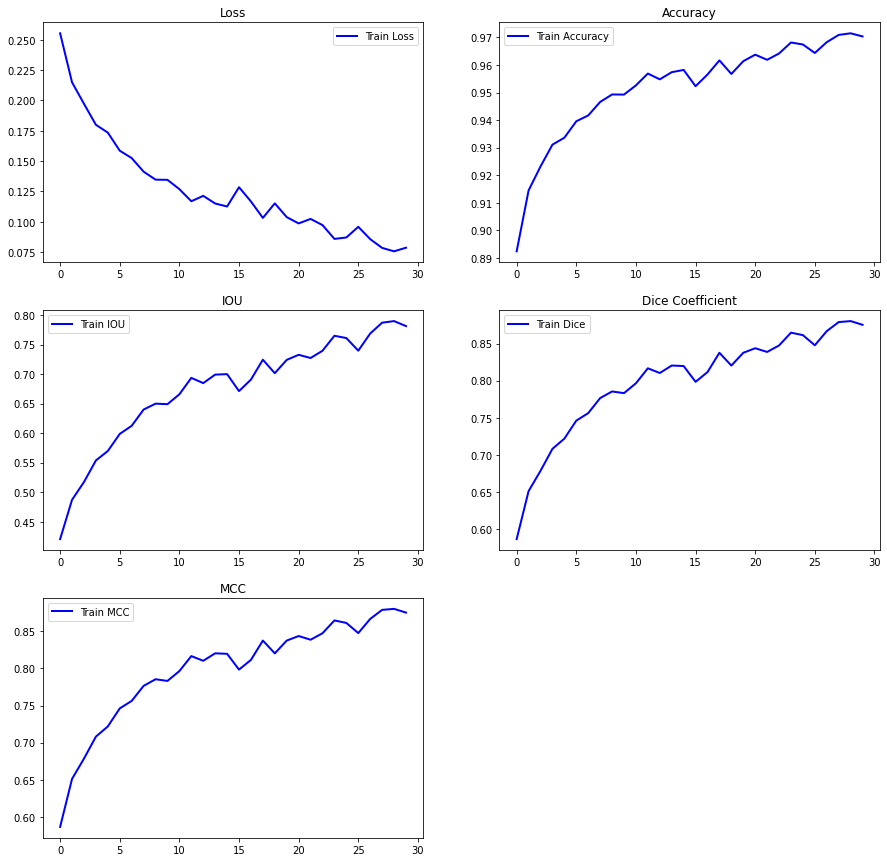

In [ ]:
# Check how loss & mae went down
epoch_loss = history['loss']
# epoch_val_loss = history.history['val_loss']
epoch_acc = history['accuracy']
# epoch_val_acc = history.history['val_acc']
epoch_jac = history['IOU']
# epoch_val_jac = history.history['IOU']
epoch_dice = history['dice_coef']
# epoch_val_dice = history.history['dice_coef']
epoch_mcc = history['mcc']
# epoch_val_mcc = history.history['mcc']

# plt.figure(figsize=(20,6))
fig = plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
# plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Loss')
plt.legend(loc='best')

plt.subplot(3,2,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train Accuracy')
# plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2, label='Val Accuracy')
plt.title('Accuracy')
plt.legend(loc='best')

plt.subplot(3,2,3)
plt.plot(range(0,len(epoch_jac)), epoch_jac, 'b-', linewidth=2, label='Train IOU')
# plt.plot(range(0,len(epoch_val_jac)), epoch_val_jac, 'r-', linewidth=2, label='Val Jacard')
plt.title('IOU')
plt.legend(loc='best')

plt.subplot(3,2,4)
plt.plot(range(0,len(epoch_dice)), epoch_dice, 'b-', linewidth=2, label='Train Dice')
# plt.plot(range(0,len(epoch_val_dice)), epoch_val_dice, 'r-', linewidth=2, label='Val Dice')
plt.title('Dice Coefficient')
plt.legend(loc='best')

plt.subplot(3,2,5)
plt.plot(range(0,len(epoch_mcc)), epoch_mcc, 'b-', linewidth=2, label='Train MCC')
# plt.plot(range(0,len(epoch_val_mcc)), epoch_val_dice, 'r-', linewidth=2, label='Val MCC')
plt.title('MCC')
plt.legend(loc='best')

plt.show()

In [ ]:
UNetModel.compile(optimizer = Adam(learning_rate=0.0005), loss = 'binary_crossentropy', metrics = [IOU, mcc, dice_coef, 'accuracy'], run_eagerly = True)
unet_model_1000images = ResumableModel(UNetModel, save_every_epochs = 3, custom_objects = ({'IOU': IOU, 'mcc': mcc,  'dice_coef': dice_coef}), to_path = '/content/drive/MyDrive/airs-minisample/weights/unet-1000images.h5')
history = unet_model_1000images.fit(x = train_X_scaler, y = train_Y_scaler, batch_size = 8, verbose = 1, epochs = 60)

Epoch 31/60
126/126 [==============================] - 55s 294ms/step - loss: 0.0756 - IOU: 0.7943 - accuracy: 0.9714 - dice_coef: 0.8832 - mcc: 0.2653
Epoch 32/60
126/126 [==============================] - 38s 299ms/step - loss: 0.0733 - IOU: 0.7962 - accuracy: 0.9723 - dice_coef: 0.8847 - mcc: 0.2579
Epoch 33/60
126/126 [==============================] - ETA: 0s - loss: 0.0827 - IOU: 0.7762 - accuracy: 0.9692 - dice_coef: 0.8720 - mcc: 0.2461
Epoch 00033: saving model to /content/drive/MyDrive/airs-minisample/weights/unet-1000images.h5
126/126 [==============================] - 39s 309ms/step - loss: 0.0827 - IOU: 0.7762 - accuracy: 0.9692 - dice_coef: 0.8720 - mcc: 0.2461
Epoch 34/60
126/126 [==============================] - 39s 310ms/step - loss: 0.0779 - IOU: 0.7836 - accuracy: 0.9707 - dice_coef: 0.8762 - mcc: 0.2516
Epoch 35/60
126/126 [==============================] - 40s 314ms/step - loss: 0.0741 - IOU: 0.7884 - accuracy: 0.9719 - dice_coef: 0.8790 - mcc: 0.2606
Epoch 36/60


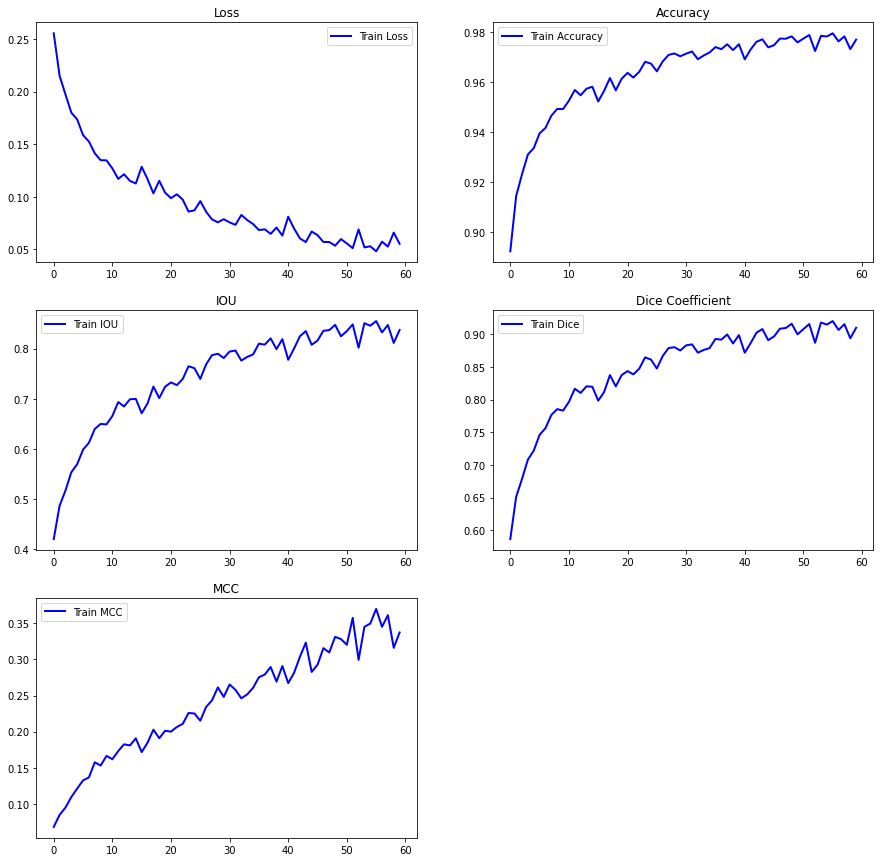

In [ ]:
# Check how loss & mae went down
epoch_loss = history['loss']
# epoch_val_loss = history.history['val_loss']
epoch_acc = history['accuracy']
# epoch_val_acc = history.history['val_acc']
epoch_jac = history['IOU']
# epoch_val_jac = history.history['IOU']
epoch_dice = history['dice_coef']
# epoch_val_dice = history.history['dice_coef']
epoch_mcc = history['mcc']
# epoch_val_mcc = history.history['mcc']

# plt.figure(figsize=(20,6))
fig = plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
# plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Loss')
plt.legend(loc='best')

plt.subplot(3,2,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train Accuracy')
# plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2, label='Val Accuracy')
plt.title('Accuracy')
plt.legend(loc='best')

plt.subplot(3,2,3)
plt.plot(range(0,len(epoch_jac)), epoch_jac, 'b-', linewidth=2, label='Train IOU')
# plt.plot(range(0,len(epoch_val_jac)), epoch_val_jac, 'r-', linewidth=2, label='Val Jacard')
plt.title('IOU')
plt.legend(loc='best')

plt.subplot(3,2,4)
plt.plot(range(0,len(epoch_dice)), epoch_dice, 'b-', linewidth=2, label='Train Dice')
# plt.plot(range(0,len(epoch_val_dice)), epoch_val_dice, 'r-', linewidth=2, label='Val Dice')
plt.title('Dice Coefficient')
plt.legend(loc='best')

plt.subplot(3,2,5)
plt.plot(range(0,len(epoch_mcc)), epoch_mcc, 'b-', linewidth=2, label='Train MCC')
# plt.plot(range(0,len(epoch_val_mcc)), epoch_val_dice, 'r-', linewidth=2, label='Val MCC')
plt.title('MCC')
plt.legend(loc='best')

plt.show()

In [ ]:
UNetModel.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = [IOU, mcc, dice_coef, 'accuracy'], run_eagerly = True)
unet_model_1000images = ResumableModel(UNetModel, save_every_epochs = 3, custom_objects = ({'IOU': IOU, 'mcc': mcc,  'dice_coef': dice_coef}), to_path = '/content/drive/MyDrive/airs-minisample/weights/unet-1000images.h5')
history = unet_model_1000images.fit(x = train_X_scaler, y = train_Y_scaler, batch_size = 16, verbose = 1, epochs = 80)

Epoch 61/80
63/63 [==============================] - 46s 563ms/step - loss: 0.0441 - IOU: 0.8705 - accuracy: 0.9805 - dice_coef: 0.9301 - mcc: 0.3678
Epoch 62/80
63/63 [==============================] - 36s 572ms/step - loss: 0.0398 - IOU: 0.8792 - accuracy: 0.9817 - dice_coef: 0.9354 - mcc: 0.4075
Epoch 63/80
63/63 [==============================] - ETA: 0s - loss: 0.0390 - IOU: 0.8814 - accuracy: 0.9821 - dice_coef: 0.9366 - mcc: 0.4033
Epoch 00063: saving model to /content/drive/MyDrive/airs-minisample/weights/unet-1000images.h5
63/63 [==============================] - 37s 591ms/step - loss: 0.0390 - IOU: 0.8814 - accuracy: 0.9821 - dice_coef: 0.9366 - mcc: 0.4033
Epoch 64/80
63/63 [==============================] - 37s 589ms/step - loss: 0.0365 - IOU: 0.8863 - accuracy: 0.9825 - dice_coef: 0.9394 - mcc: 0.4329
Epoch 65/80
63/63 [==============================] - 37s 593ms/step - loss: 0.0367 - IOU: 0.8885 - accuracy: 0.9826 - dice_coef: 0.9406 - mcc: 0.4400
Epoch 66/80
63/63 [=====

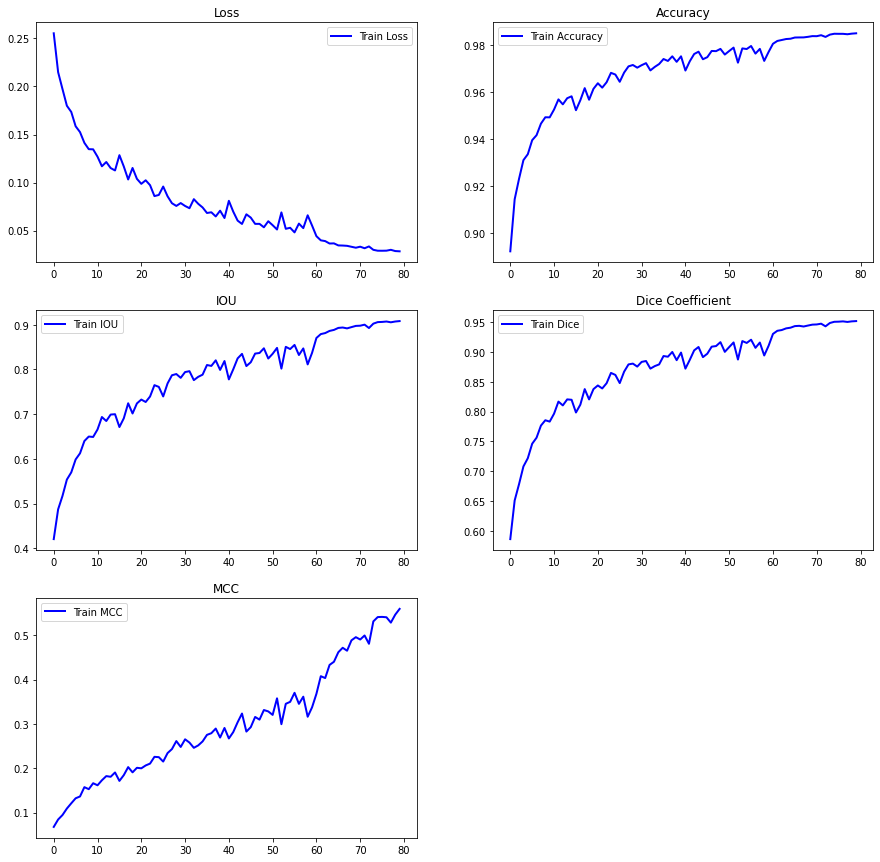

In [ ]:
# Check how loss & mae went down
epoch_loss = history['loss']
# epoch_val_loss = history.history['val_loss']
epoch_acc = history['accuracy']
# epoch_val_acc = history.history['val_acc']
epoch_jac = history['IOU']
# epoch_val_jac = history.history['IOU']
epoch_dice = history['dice_coef']
# epoch_val_dice = history.history['dice_coef']
epoch_mcc = history['mcc']
# epoch_val_mcc = history.history['mcc']

# plt.figure(figsize=(20,6))
fig = plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
# plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Loss')
plt.legend(loc='best')

plt.subplot(3,2,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train Accuracy')
# plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2, label='Val Accuracy')
plt.title('Accuracy')
plt.legend(loc='best')

plt.subplot(3,2,3)
plt.plot(range(0,len(epoch_jac)), epoch_jac, 'b-', linewidth=2, label='Train IOU')
# plt.plot(range(0,len(epoch_val_jac)), epoch_val_jac, 'r-', linewidth=2, label='Val Jacard')
plt.title('IOU')
plt.legend(loc='best')

plt.subplot(3,2,4)
plt.plot(range(0,len(epoch_dice)), epoch_dice, 'b-', linewidth=2, label='Train Dice')
# plt.plot(range(0,len(epoch_val_dice)), epoch_val_dice, 'r-', linewidth=2, label='Val Dice')
plt.title('Dice Coefficient')
plt.legend(loc='best')

plt.subplot(3,2,5)
plt.plot(range(0,len(epoch_mcc)), epoch_mcc, 'b-', linewidth=2, label='Train MCC')
# plt.plot(range(0,len(epoch_val_mcc)), epoch_val_dice, 'r-', linewidth=2, label='Val MCC')
plt.title('MCC')
plt.legend(loc='best')

plt.show()

In [ ]:
from keras.models import load_model
u_net = UNetModel.load_weights('/content/drive/MyDrive/airs-minisample/weights/unet-1000images.h5')

In [ ]:
rows = 6
columns = 3
count = 1
for image_number in range(0,5):

  fig = plt.figure(figsize=(15,15))
  print('Image number: {0}'.format(image_number))
  pred_y_MCC = u_net.predict(val_X[image_number:image_number+1])
  pred_y_MCC = pred_y_MCC / 255.

  fig.add_subplot(rows, columns, count)
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(val_X[image_number:image_number+1]))
  plt.title('Aerial view')

  fig.add_subplot(rows, columns, count+1)
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(val_Y[image_number:image_number+1]))
  plt.title('Original')

  fig.add_subplot(rows, columns, count+2)
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred_y_MCC[0]))
  plt.title('Segmented')
  count += 3

  plt.show()

Image number: 0


AttributeError: ignored

<Figure size 1080x1080 with 0 Axes>

Image number: 0


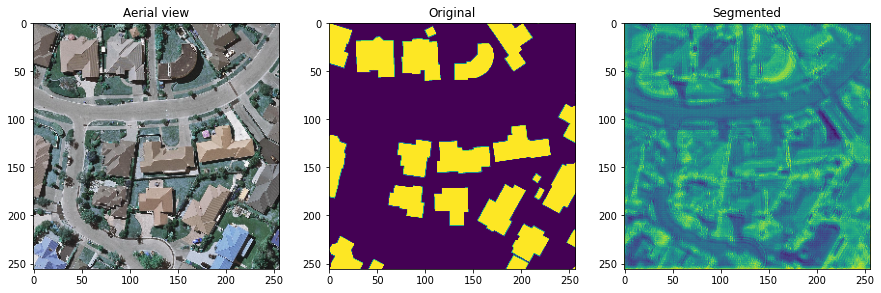

Image number: 1


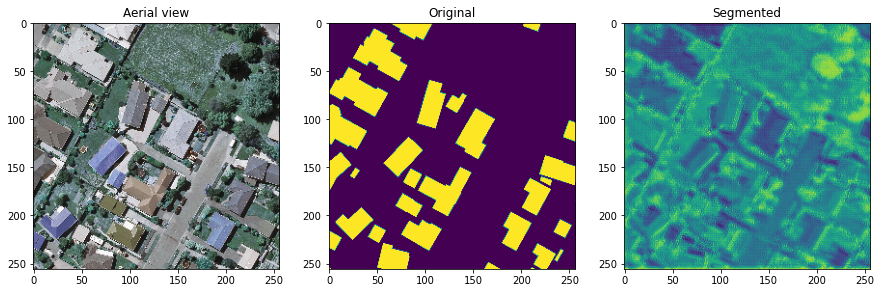

Image number: 2


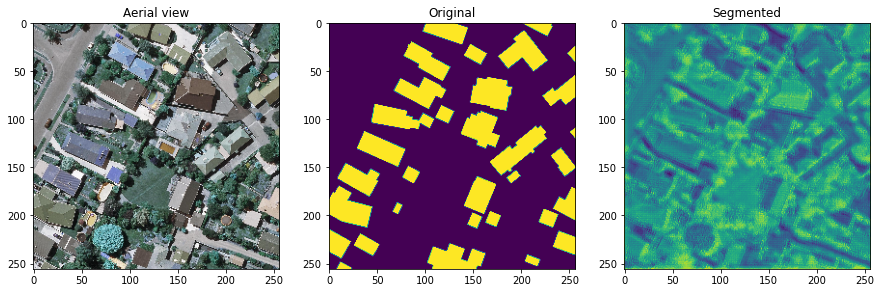

Image number: 3


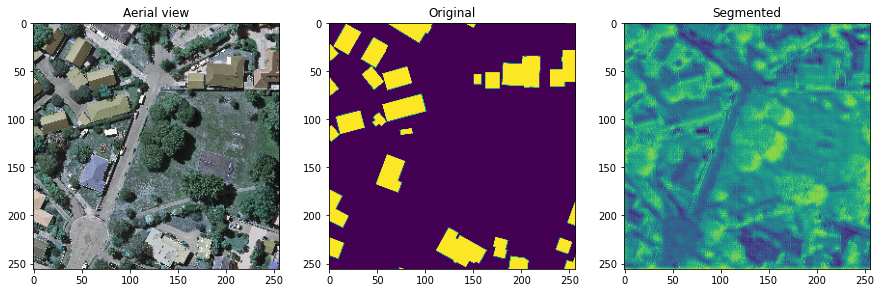

Image number: 4


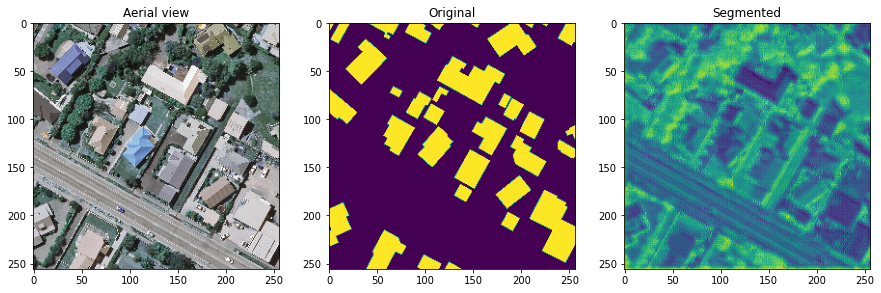

In [ ]:
rows = 6
columns = 3
count = 1
for image_number in range(0,5):

  fig = plt.figure(figsize=(15,15))
  print('Image number: {0}'.format(image_number))
  pred_y_MCC = UNetModel.predict(val_X[image_number:image_number+1])
  pred_y_MCC = pred_y_MCC / 255.

  fig.add_subplot(rows, columns, count)
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(val_X[image_number:image_number+1]))
  plt.title('Aerial view')

  fig.add_subplot(rows, columns, count+1)
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(val_Y[image_number:image_number+1]))
  plt.title('Original')

  fig.add_subplot(rows, columns, count+2)
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred_y_MCC[0]))
  plt.title('Segmented')
  count += 3

  plt.show()

In [ ]:
# Check how to store as JSON
history = UNetModel.fit(x = train_X_scaler, y = train_Y_scaler, batch_size = 16, epochs = 10, verbose = 1)

Epoch 1/10
63/63 [==============================] - 74s 897ms/step - loss: 0.2732 - jacard_coef: 0.4001 - accuracy: 0.8860 - dice_coef: 0.5647
Epoch 2/10
63/63 [==============================] - 59s 933ms/step - loss: 0.2095 - jacard_coef: 0.5038 - accuracy: 0.9180 - dice_coef: 0.6682
Epoch 3/10
63/63 [==============================] - 59s 933ms/step - loss: 0.1968 - jacard_coef: 0.5226 - accuracy: 0.9237 - dice_coef: 0.6844
Epoch 4/10
63/63 [==============================] - 59s 939ms/step - loss: 0.1782 - jacard_coef: 0.5636 - accuracy: 0.9303 - dice_coef: 0.7189
Epoch 5/10
63/63 [==============================] - 59s 935ms/step - loss: 0.1671 - jacard_coef: 0.5801 - accuracy: 0.9357 - dice_coef: 0.7329
Epoch 6/10
63/63 [==============================] - 59s 937ms/step - loss: 0.1582 - jacard_coef: 0.5985 - accuracy: 0.9385 - dice_coef: 0.7456
Epoch 7/10
63/63 [==============================] - 59s 935ms/step - loss: 0.1625 - jacard_coef: 0.5886 - accuracy: 0.9354 - dice_coef: 0.7375

In [ ]:
UNetModel.save_weights('/content/drive/MyDrive/airs-minisample/weights/unet-youtube-1000images-10epochs.h5')
UNetModel.save_weights('/content/drive/MyDrive/airs-minisample/weights/unet-youtube-1000images-10epochs.tf')

### **Graph**

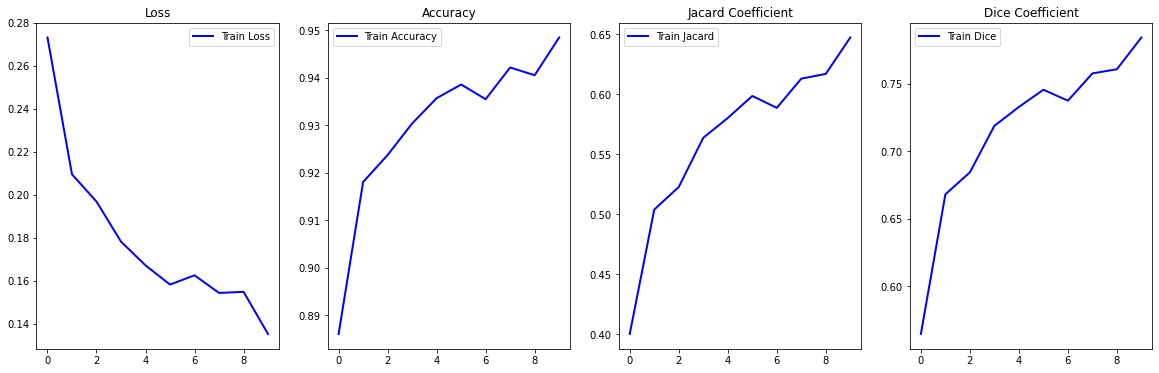

In [ ]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
# epoch_val_loss = history.history['val_loss']
epoch_acc = history.history['accuracy']
# epoch_val_acc = history.history['val_acc']
epoch_jac = history.history['IOU']
# epoch_val_jac = history.history['IOU']
epoch_dice = history.history['dice_coef']
# epoch_val_dice = history.history['dice_coef']
epoch_mcc = history.history['mcc']
# epoch_val_mcc = history.history['mcc']

# plt.figure(figsize=(20,6))
fig = plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
# plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Loss')
plt.legend(loc='best')

plt.subplot(3,2,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train Accuracy')
# plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2, label='Val Accuracy')
plt.title('Accuracy')
plt.legend(loc='best')

plt.subplot(3,2,3)
plt.plot(range(0,len(epoch_jac)), epoch_jac, 'b-', linewidth=2, label='Train IOU')
# plt.plot(range(0,len(epoch_val_jac)), epoch_val_jac, 'r-', linewidth=2, label='Val Jacard')
plt.title('IOU')
plt.legend(loc='best')

plt.subplot(3,2,4)
plt.plot(range(0,len(epoch_dice)), epoch_dice, 'b-', linewidth=2, label='Train Dice')
# plt.plot(range(0,len(epoch_val_dice)), epoch_val_dice, 'r-', linewidth=2, label='Val Dice')
plt.title('Dice Coefficient')
plt.legend(loc='best')

plt.subplot(3,2,5)
plt.plot(range(0,len(epoch_mcc)), epoch_dice, 'b-', linewidth=2, label='Train MCC')
# plt.plot(range(0,len(epoch_val_mcc)), epoch_val_dice, 'r-', linewidth=2, label='Val MCC')
plt.title('MCC')
plt.legend(loc='best')

plt.show()

### **Prediction on val image**

In [ ]:
plt.figure(figsize=(15,15))
image_number = 6
print('Image number: {0}'.format(image_number))
pred_y = UNetModel2.predict(val_X[image_number:image_number+1])
pred_y = pred_y / 255.
# pred_y = np.round(pred_y,0)

plt.subplot(1,3,1)
plt.imshow(np.squeeze(val_X[image_number:image_number+1]))
plt.title('Aerial view')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(val_Y[image_number:image_number+1]))
plt.title('Original')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(pred_y[0]))
plt.title('Segmented')

plt.show()

NameError: ignored

In [ ]:
# tf.cast(inp, tf.float32)
print(jacard_coef(tf.cast(val_Y[16:17][0], tf.float32), tf.cast(pred_y[0], tf.float32)))

tf.Tensor(0.0010389038, shape=(), dtype=float32)


In [ ]:
UNetModel2 = satellite_unet(input_shape=(256, 256, 3))
UNetModel2.compile(optimizer = Adam(lr=0.0001), loss = 'binary_crossentropy', metrics = [IOU, mcc, dice_coef, 'accuracy'], run_eagerly = True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history_2 = UNetModel2.fit(x = train_X_scaler, y = train_Y_scaler, batch_size = 8, epochs = 100, verbose = 1)

Epoch 1/100
126/126 [==============================] - 74s 459ms/step - loss: 0.3679 - IOU: 0.3102 - mcc: 0.0301 - dice_coef: 0.4653 - accuracy: 0.8352
Epoch 2/100
126/126 [==============================] - 59s 467ms/step - loss: 0.2524 - IOU: 0.4188 - mcc: 0.0588 - dice_coef: 0.5876 - accuracy: 0.8948
Epoch 3/100
126/126 [==============================] - 60s 474ms/step - loss: 0.2306 - IOU: 0.4541 - mcc: 0.0700 - dice_coef: 0.6210 - accuracy: 0.9059
Epoch 4/100
126/126 [==============================] - 60s 479ms/step - loss: 0.2170 - IOU: 0.4798 - mcc: 0.0782 - dice_coef: 0.6444 - accuracy: 0.9126
Epoch 5/100
126/126 [==============================] - 61s 482ms/step - loss: 0.2023 - IOU: 0.5104 - mcc: 0.0871 - dice_coef: 0.6730 - accuracy: 0.9215
Epoch 6/100
126/126 [==============================] - 61s 483ms/step - loss: 0.1908 - IOU: 0.5301 - mcc: 0.0965 - dice_coef: 0.6885 - accuracy: 0.9242
Epoch 7/100
126/126 [==============================] - 61s 483ms/step - loss: 0.1819 - I

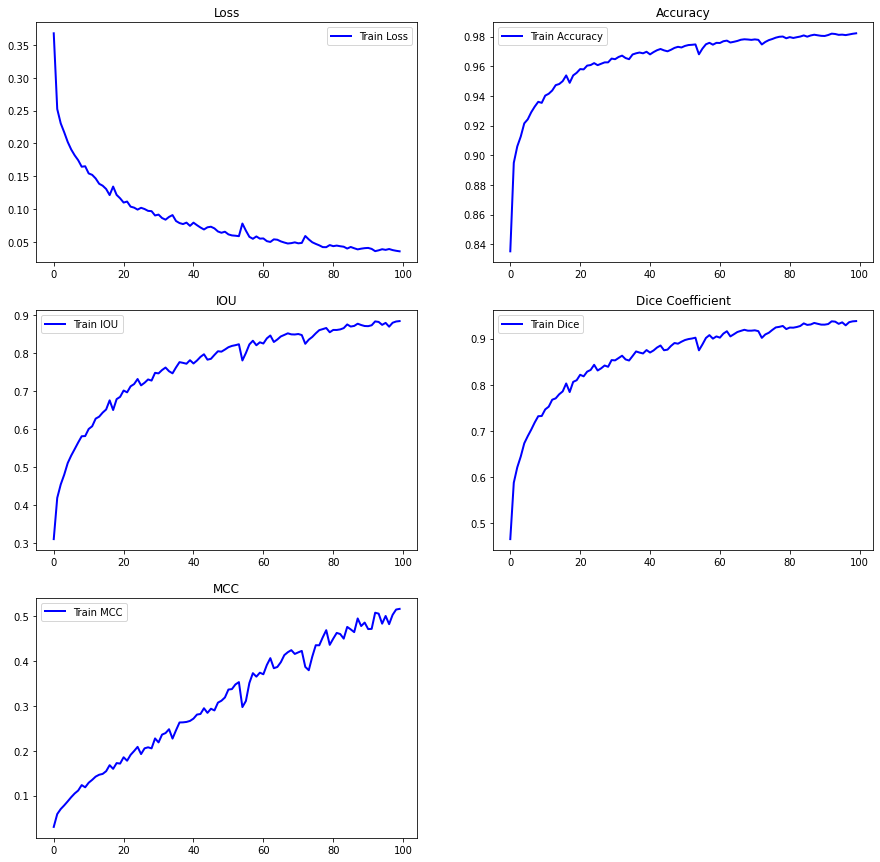

In [ ]:
# Check how loss & mae went down
epoch_loss = history_2.history['loss']
# epoch_val_loss = history_2.history['val_loss']
epoch_acc = history_2.history['accuracy']
# epoch_val_acc = history_2.history['val_acc']
epoch_jac = history_2.history['IOU']
# epoch_val_jac = history_2.history['IOU']
epoch_dice = history_2.history['dice_coef']
# epoch_val_dice = history_2.history['dice_coef']
epoch_mcc = history_2.history['mcc']
# epoch_val_mcc = history_2.history['mcc']

# plt.figure(figsize=(20,6))
fig = plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
# plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Loss')
plt.legend(loc='best')

plt.subplot(3,2,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train Accuracy')
# plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2, label='Val Accuracy')
plt.title('Accuracy')
plt.legend(loc='best')

plt.subplot(3,2,3)
plt.plot(range(0,len(epoch_jac)), epoch_jac, 'b-', linewidth=2, label='Train IOU')
# plt.plot(range(0,len(epoch_val_jac)), epoch_val_jac, 'r-', linewidth=2, label='Val Jacard')
plt.title('IOU')
plt.legend(loc='best')

plt.subplot(3,2,4)
plt.plot(range(0,len(epoch_dice)), epoch_dice, 'b-', linewidth=2, label='Train Dice')
# plt.plot(range(0,len(epoch_val_dice)), epoch_val_dice, 'r-', linewidth=2, label='Val Dice')
plt.title('Dice Coefficient')
plt.legend(loc='best')

plt.subplot(3,2,5)
plt.plot(range(0,len(epoch_mcc)), epoch_mcc, 'b-', linewidth=2, label='Train MCC')
# plt.plot(range(0,len(epoch_val_mcc)), epoch_val_dice, 'r-', linewidth=2, label='Val MCC')
plt.title('MCC')
plt.legend(loc='best')

plt.show()

In [ ]:
UNetModel2.save('/content/drive/MyDrive/airs-minisample/weights/unet2-1000images-100epochs.h5')
UNetModel2.save_weights('/content/drive/MyDrive/airs-minisample/weights/unet2-weights-1000images-100epochs.h5')
UNetModel2.save_weights('/content/drive/MyDrive/airs-minisample/weights/unet2-weights-1000images-100epochs.tf')

Image number: 0


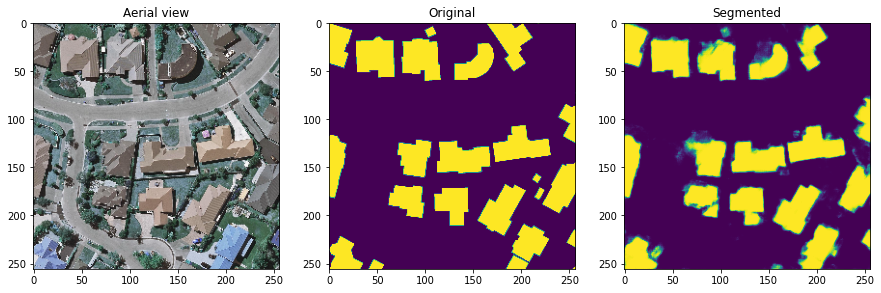

Image number: 1


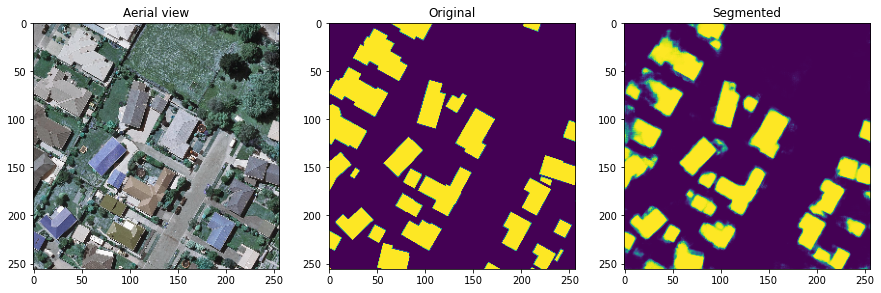

Image number: 2


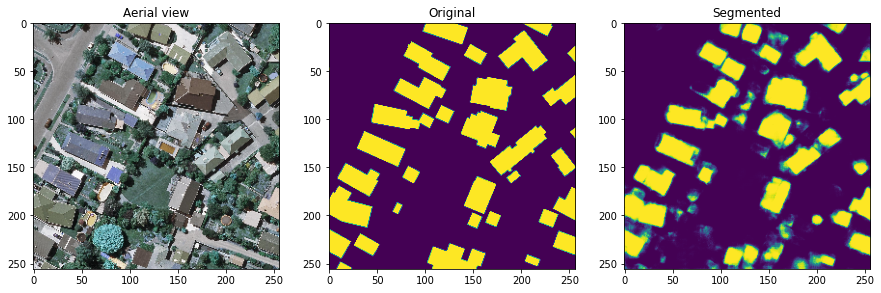

Image number: 3


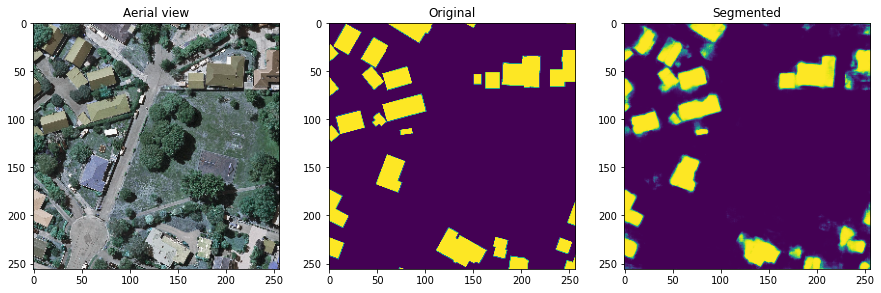

Image number: 4


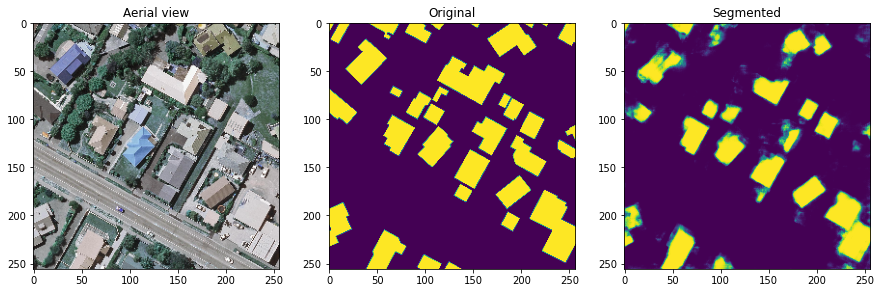

In [ ]:
rows = 6
columns = 3
count = 1
for image_number in range(0,5):

  fig = plt.figure(figsize=(15,15))
  print('Image number: {0}'.format(image_number))
  pred_y_MCC = UNetModel2.predict(val_X[image_number:image_number+1])
  pred_y_MCC = pred_y_MCC / 255.

  fig.add_subplot(rows, columns, count)
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(val_X[image_number:image_number+1]))
  plt.title('Aerial view')

  fig.add_subplot(rows, columns, count+1)
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(val_Y[image_number:image_number+1]))
  plt.title('Original')

  fig.add_subplot(rows, columns, count+2)
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred_y_MCC[0]))
  plt.title('Segmented')
  count += 3

  plt.show()

In [ ]:
UNetModel2_v2 = load_model('/content/drive/MyDrive/airs-minisample/weights/unet2-1000images-100epochs.h5', custom_objects = ({'IOU': IOU, 'mcc': mcc,  'dice_coef': dice_coef}))

In [ ]:
UNetModel2_v2.compile(optimizer = Adam(lr=0.00001), loss = 'binary_crossentropy', metrics = [IOU, mcc, dice_coef, 'accuracy'], run_eagerly = True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history_2 = UNetModel2_v2.fit(x = train_X_scaler, y = train_Y_scaler, batch_size = 8, epochs = 130, verbose = 1, initial_epoch=100)

Epoch 101/130
126/126 [==============================] - 140s 1s/step - loss: 0.0302 - IOU: 0.8985 - mcc: 0.5537 - dice_coef: 0.9461 - accuracy: 0.9840
Epoch 102/130
126/126 [==============================] - 140s 1s/step - loss: 0.0304 - IOU: 0.8983 - mcc: 0.5517 - dice_coef: 0.9461 - accuracy: 0.9839
Epoch 103/130
126/126 [==============================] - 140s 1s/step - loss: 0.0303 - IOU: 0.8985 - mcc: 0.5519 - dice_coef: 0.9461 - accuracy: 0.9840
Epoch 104/130
126/126 [==============================] - 140s 1s/step - loss: 0.0305 - IOU: 0.8968 - mcc: 0.5485 - dice_coef: 0.9451 - accuracy: 0.9838
Epoch 105/130
126/126 [==============================] - 140s 1s/step - loss: 0.0298 - IOU: 0.9016 - mcc: 0.5538 - dice_coef: 0.9480 - accuracy: 0.9841
Epoch 106/130
126/126 [==============================] - 140s 1s/step - loss: 0.0294 - IOU: 0.9031 - mcc: 0.5728 - dice_coef: 0.9488 - accuracy: 0.9842
Epoch 107/130
126/126 [==============================] - 140s 1s/step - loss: 0.0295 - I

In [ ]:
UNetModel2_v2.save('/content/drive/MyDrive/airs-minisample/weights/unet2-1000images-130epochs.h5')
UNetModel2_v2.save_weights('/content/drive/MyDrive/airs-minisample/weights/unet2-weights-1000images-130epochs.h5')
UNetModel2_v2.save_weights('/content/drive/MyDrive/airs-minisample/weights/unet2-weights-1000images-130epochs.tf')

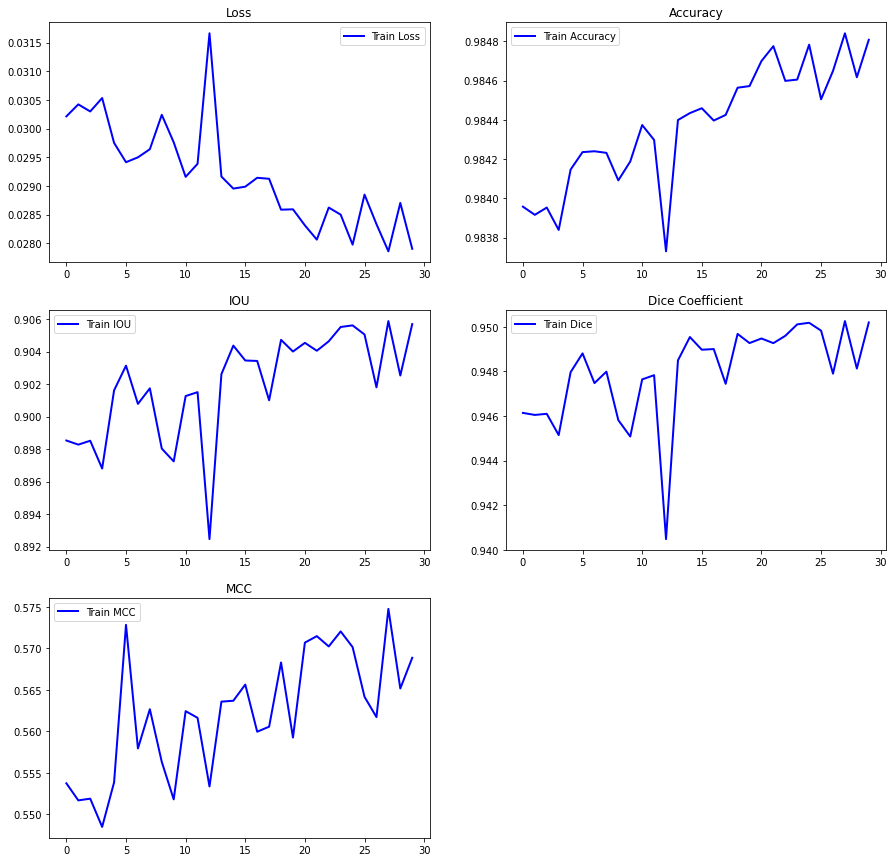

In [ ]:
# Check how loss & mae went down
epoch_loss = history_2.history['loss']
# epoch_val_loss = history_2.history['val_loss']
epoch_acc = history_2.history['accuracy']
# epoch_val_acc = history_2.history['val_acc']
epoch_jac = history_2.history['IOU']
# epoch_val_jac = history_2.history['IOU']
epoch_dice = history_2.history['dice_coef']
# epoch_val_dice = history_2.history['dice_coef']
epoch_mcc = history_2.history['mcc']
# epoch_val_mcc = history_2.history['mcc']

# plt.figure(figsize=(20,6))
fig = plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
# plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Loss')
plt.legend(loc='best')

plt.subplot(3,2,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train Accuracy')
# plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2, label='Val Accuracy')
plt.title('Accuracy')
plt.legend(loc='best')

plt.subplot(3,2,3)
plt.plot(range(0,len(epoch_jac)), epoch_jac, 'b-', linewidth=2, label='Train IOU')
# plt.plot(range(0,len(epoch_val_jac)), epoch_val_jac, 'r-', linewidth=2, label='Val Jacard')
plt.title('IOU')
plt.legend(loc='best')

plt.subplot(3,2,4)
plt.plot(range(0,len(epoch_dice)), epoch_dice, 'b-', linewidth=2, label='Train Dice')
# plt.plot(range(0,len(epoch_val_dice)), epoch_val_dice, 'r-', linewidth=2, label='Val Dice')
plt.title('Dice Coefficient')
plt.legend(loc='best')

plt.subplot(3,2,5)
plt.plot(range(0,len(epoch_mcc)), epoch_mcc, 'b-', linewidth=2, label='Train MCC')
# plt.plot(range(0,len(epoch_val_mcc)), epoch_val_dice, 'r-', linewidth=2, label='Val MCC')
plt.title('MCC')
plt.legend(loc='best')

plt.show()

Image number: 0


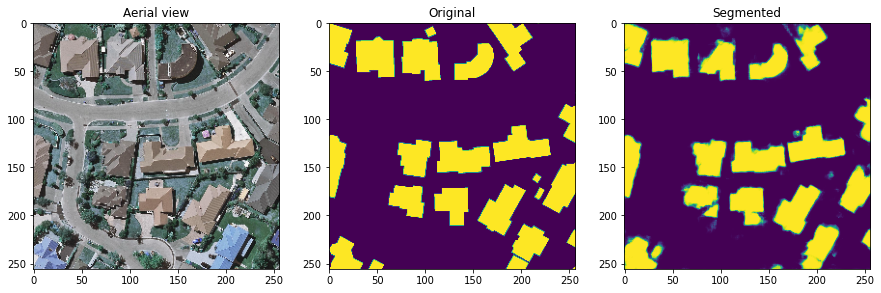

Image number: 1


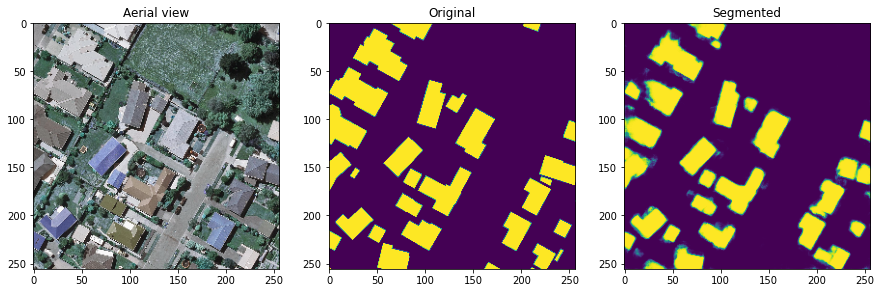

Image number: 2


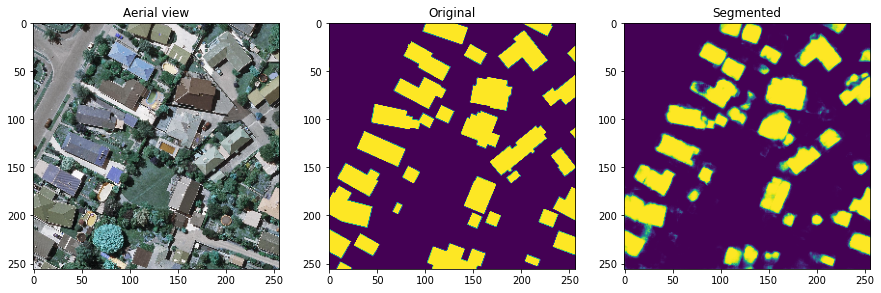

Image number: 3


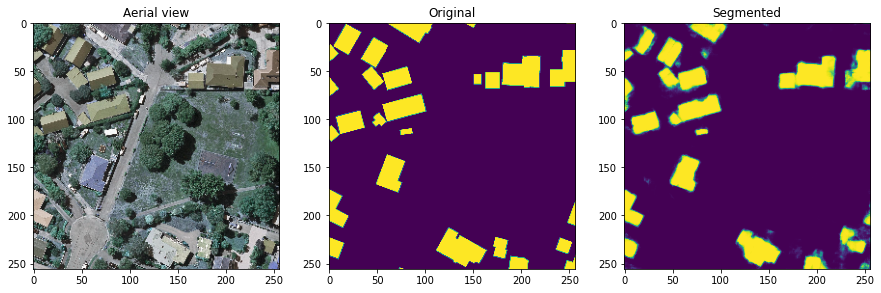

Image number: 4


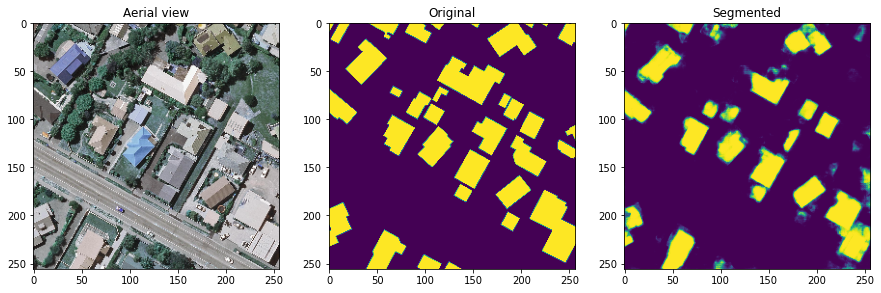

In [ ]:
rows = 6
columns = 3
count = 1
for image_number in range(0,5):

  fig = plt.figure(figsize=(15,15))
  print('Image number: {0}'.format(image_number))
  pred_y_MCC = UNetModel2_v2.predict(val_X[image_number:image_number+1])
  pred_y_MCC = pred_y_MCC / 255.

  fig.add_subplot(rows, columns, count)
  plt.subplot(1,3,1)
  plt.imshow(np.squeeze(val_X[image_number:image_number+1]))
  plt.title('Aerial view')

  fig.add_subplot(rows, columns, count+1)
  plt.subplot(1,3,2)
  plt.imshow(np.squeeze(val_Y[image_number:image_number+1]))
  plt.title('Original')

  fig.add_subplot(rows, columns, count+2)
  plt.subplot(1,3,3)
  plt.imshow(np.squeeze(pred_y_MCC[0]))
  plt.title('Segmented')
  count += 3

  plt.show()